<a href="https://colab.research.google.com/github/mengjie514/twitter_works/blob/master/psiv_eda_model_training_comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**3. Exploratory Data Analysis (EDA)**

In [ ]:
import os
from google.colab import drive
drive.mount('/content/gdrive')
os.chdir("/content/gdrive/My Drive/Colab Notebooks/PSIV")
import pandas as pd
import numpy as np
pd.set_option('display.max_colwidth', -1)

df = pd.read_excel('output_for_R_0.65.xlsx')
df = df[['care', 'harm','fairness','cheating','loyalty','betrayal','authority','subversion', 'purity','degradation','non-moral','annotation_main','new_clean_text','new_clean_text_deep_stem','Corpus']]

df.columns = ['care0', 'harm0','fairness0','cheating0','loyalty0','betrayal0','authority0','subversion0', 'purity0','degradation0','non-moral0','annotation_main','new_clean_text','new_clean_text_deep_stem','Corpus']
df = df[df['new_clean_text_deep_stem'].notna()]
df = df[df['annotation_main'].notna()]

# New application - remove Davidson as it has the lowest accuracte outcome ()
df = df.loc[df["Corpus"] != 'Davidson', ]
df.reset_index(inplace=True)

# copy a df for word counts
df_words = df

print("Number of rows in data =", df.shape[0])
print("Number of columns in data =", df.shape[1])
print("\n")
print("**Sample data:**")
df.head(1)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  import sys


Number of rows in data = 21856
Number of columns in data = 16


**Sample data:**


,index,care0,harm0,fairness0,cheating0,loyalty0,betrayal0,authority0,subversion0,purity0,degradation0,non-moral0,annotation_main,new_clean_text,new_clean_text_deep_stem,Corpus
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,care,Peace and Love Prevail. God Bless.,peac love prevail god bless,ALM


**3.1 Turning annotation list into set of columns of binary data**

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer

annotation_new=[]

for cell in df['annotation_main']:
    cell=cell.replace(" ", "") 
    cell=cell.replace("&", "& ") 
    annotation_new.append(cell.split(","))

df['annotation_new'] = annotation_new 

mlb = MultiLabelBinarizer() 
binary_labels=pd.DataFrame(mlb.fit_transform(df['annotation_new']),columns=mlb.classes_) 
binary_labels=binary_labels.sort_index(axis=1) 

df = df.join(binary_labels)
df = df[['new_clean_text_deep_stem', 'care', 'harm','fairness','cheating','loyalty','betrayal','authority','subversion', 'purity','degradation','non-moral']]

df.head(1)

,new_clean_text_deep_stem,care,harm,fairness,cheating,loyalty,betrayal,authority,subversion,purity,degradation,non-moral
0,peac love prevail god bless,1,0,0,0,0,0,0,0,0,0,0


**3.2 Count number of texts under each/multi labels**

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


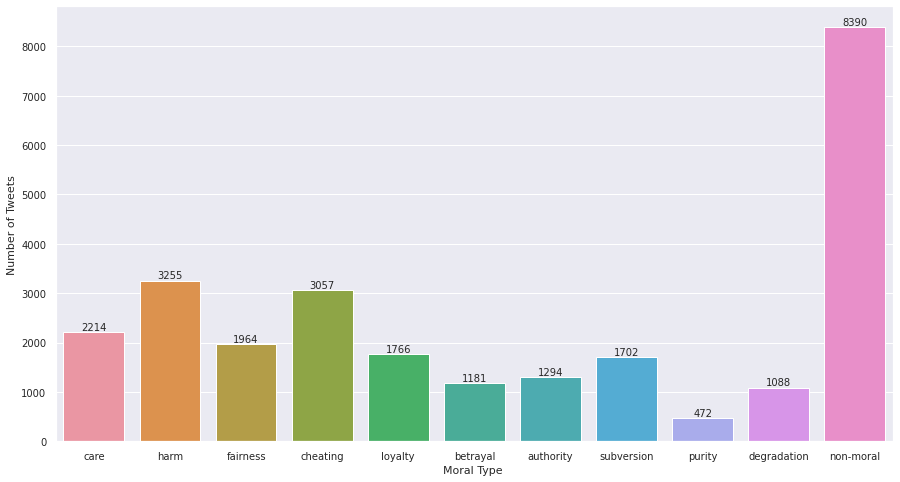

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

categories = list(df.iloc[:,1:].columns.values)
sns.set(font_scale = 2)
plt.figure(figsize=(15,8))

ax= sns.barplot(categories, df.iloc[:,1:].sum().values)
ax.tick_params(axis = 'both', which = 'major', labelsize = 10)
ax.tick_params(axis = 'both', which = 'minor', labelsize = 10)
plt.ylabel('Number of Tweets', fontsize=11)
plt.xlabel('Moral Type ', fontsize=11)

rects = ax.patches
labels = df.iloc[:,1:].sum().values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom', fontsize=10)
plt.show()

**3.3 Count number of texts having multi labels**

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


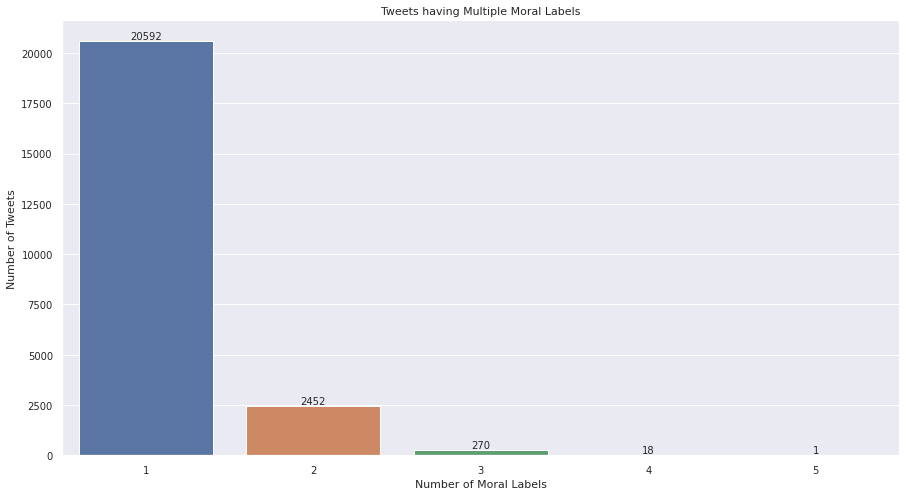

In [ ]:
rowSums = df.iloc[:,1:].sum(axis=1)
multiLabel_counts = rowSums.value_counts()
multiLabel_counts = multiLabel_counts.iloc[0:]
sns.set(font_scale = 2)
plt.figure(figsize=(15,8))
ax = sns.barplot(multiLabel_counts.index, multiLabel_counts.values)
ax.tick_params(axis = 'both', which = 'major', labelsize = 10)
ax.tick_params(axis = 'both', which = 'minor', labelsize = 10)
plt.title("Tweets having Multiple Moral Labels", fontsize=11)
plt.ylabel('Number of Tweets', fontsize=11)
plt.xlabel('Number of Moral Labels', fontsize=11)

rects = ax.patches
labels = multiLabel_counts.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom', fontsize=10)
plt.show()

**3.4 Words frequency under each label**

In [ ]:
import nltk

def orig(df):
    s = df_words["annotation_main"].str.split(',').apply(pd.Series,1).stack()
    s.index = s.index.droplevel(-1)
    s.name = "annotation_split"
    return df.join(s)

df = %time orig(df.copy())

# count words frequency grouped by label
nltk.download('punkt')
output = pd.DataFrame(df.groupby('annotation_split')['new_clean_text_deep_stem'].apply(lambda x: nltk.FreqDist(nltk.tokenize.word_tokenize(' '.join(x)))))
output = output.reset_index().rename(columns={df.index.name:'annotation_split','level_1':'words','new_clean_text_deep_stem':'count'})

output['high_freq'] = np.where(output['count'] >= 100.0, 'Y', 'N')

# present high-frequent words for each label
df_agg = output[output.high_freq == 'Y'].groupby(['annotation_split','words']).agg({'count':sum})
g = df_agg['count'].groupby('annotation_split', group_keys=False)

print("\n")
print("**Count the most common words per label:**")
pd.set_option('display.max_colwidth', -1)
print(g.apply(lambda x: x.sort_values(ascending=False).head(3)))

CPU times: user 4.73 s, sys: 208 ms, total: 4.93 s
Wall time: 4.65 s
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


**Count the most common words per label:**
annotation_split  words   
authority         respect     407.0 
                  obey        383.0 
                  law         345.0 
betrayal          traitor     351.0 
                  not         185.0 
                  peopl       136.0 
care              sandi       608.0 
                  love        541.0 
                  compass     435.0 
cheating          not         483.0 
                  injustic    481.0 
                  fraud       365.0 
degradation       disgust     180.0 
                  traitor     128.0 
                  sin         127.0 
fairness          justic      1148.0
                  equal       528.0 
                  right       368.0 
harm              sandi       631.0 
                  not         531.0 
             

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.


**4. Modelling**

There exists multiple techniques how to solve a multi-label classification.

**4.1 Problem Transformation**

Divide the multi-label problem into one or more conventional single-label problems:

*   Binary classification transformation (OneVsRest) — to divide the problem into several independent binary classification tasks
*   Classifer Chain (ClassifierChain) — similar to binary relevance, difference being it forms chains in order to preserve label correlation
*    Multi-class classification transformation (Label Powerset) — map out each combination of labels into a single label and trains a single label classifier

**4.2 Word Embedding**

There are different techniques to extract information from raw text data and use it to train a classification model:

*   The Bag-of-Words model builds a vocabulary from a corpus of documents and counts how many times the words appear in each document.
*   Instead of simple counting, uses the term frequency–inverse document frequency (or Tf–Idf) is intended to reflect how important a word is to a document in a collection or corpus.
*   Word2Vec produces a vector space, typically of several hundred dimensions, with each unique word in the corpus such that words that share common contexts in the corpus are located close to one another in the space.
*   GloVe

In [ ]:
! pip install scikit-multilearn
import sklearn
from sklearn import feature_extraction
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, roc_curve, confusion_matrix, multilabel_confusion_matrix, classification_report
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multioutput import MultiOutputClassifier
from skmultilearn.problem_transform import ClassifierChain, LabelPowerset
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

seeds = [1, 43, 678, 90, 135]
X_train, X_test, y_train, y_test = train_test_split(df['new_clean_text_deep_stem'], 
                                                    df.drop(['new_clean_text_deep_stem'], axis=1),
                                                    test_size=0.3, 
                                                    random_state=seeds[0],
                                                    shuffle=True)
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(15299,) (15299, 11)
(6557,) (6557, 11)


In [ ]:
##Classic BoW
vectorizer = feature_extraction.text.CountVectorizer(max_features=5000)
vectorizer.fit(X_train)

X_train = vectorizer.transform(X_train)
X_test = vectorizer.transform(X_test)

labels = ['care', 'harm', 'fairness', 'cheating', 'loyalty', 'betrayal', 'authority', 'subversion', 'purity', 'degradation', 'non-moral'] 

def run_pipeline(pipeline, X_train, y_train, X_test, y_test):
    pipeline.fit(X_train, y_train)
    predictions = pipeline.predict(X_test)
    print(roc_auc_score(y_test, predictions)) # or + average = 'samples'; roc_auc_score(y_test, predictions.toarray()) for ClassifierChain
    #print(classification_report(y_test, predictions, target_names=labels))

run_pipeline(Pipeline([('clf', MultiOutputClassifier(LogisticRegression()))]), # MultinomialNB vs. LogisticRegression(solver='sag') vs. LinearSVC vs. RandomForestClassifier vs. xgb.XGBClassifier
             X_train, y_train, X_test, y_test)                                  # OneVsRestClassifier (n_jobs = -1) vs. ClassifierChain vs. MultiOutputClassifier

0.7501762210329914


In [ ]:
##Tf-Idf
vectorizer = TfidfVectorizer(max_features=5000, strip_accents='unicode', analyzer='word', ngram_range=(1,3), norm='l2')
vectorizer.fit(X_train)

X_train = vectorizer.transform(X_train)
X_test = vectorizer.transform(X_test)

run_pipeline(Pipeline([('clf', ClassifierChain(MultinomialNB()))]), 
             X_train, y_train, X_test, y_test)               

In [ ]:
##Word embedding (Word2Vec)
import gensim
from gensim.models import Word2Vec

combined_df = X_train.append(X_test)

Vocab_list = (combined_df.apply(lambda x:str(x).strip().split()))
models = Word2Vec(Vocab_list,size=100)
WordVectorz = dict(zip(models.wv.index2word,models.wv.vectors))

#fit these things into a pipeline
class AverageEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = 100 # as we use 100 embedding points 

    def fit(self, X, y):
        return self

    def transform(self, X): #average of all the word vectors that make up the sentence
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])

run_pipeline(Pipeline([("wordVectz",AverageEmbeddingVectorizer(WordVectorz)),
                       ("multilabel",ClassifierChain(LogisticRegression()))]),
                        X_train, y_train, X_test, y_test)

In [ ]:
##Word embedding (GloVe)
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from nltk import word_tokenize
import nltk
nltk.download('punkt')
import tqdm
from tqdm import tqdm
from numpy import array, asarray, zeros

tokenizer = Tokenizer(num_words=5000, lower=True)
tokenizer.fit_on_texts(df.new_clean_text_deep_stem)
sequences = tokenizer.texts_to_sequences(df.new_clean_text_deep_stem)
x = pad_sequences(sequences, maxlen=200)

X_train, X_test, y_train, y_test = train_test_split(x, 
                                                    df[df.columns[1:]],
                                                    test_size=0.3, 
                                                    random_state=seeds[4])
        
embeddings_dictionary = dict()
glove_file = open('glove.6B.100d.txt', encoding="utf8")
for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

def sent2vec(s):
    words = str(s).lower()
    words = word_tokenize(words)
    M = []
    for w in words:
        try:
            M.append(embeddings_dictionary[w])
        except:
            continue
    M = np.array(M)
    v = M.sum(axis=0)
    if type(v) != np.ndarray:
        return np.zeros(300)
    return v / np.sqrt((v ** 2).sum())

X_train = [sent2vec(x) for x in tqdm(X_train)]
X_test = [sent2vec(x) for x in tqdm(X_test)]

run_pipeline(Pipeline([('clf', ClassifierChain(LogisticRegression()))]),
             X_train, y_train, X_test, y_test)

**4.3 Results (ML)**

In [ ]:
arrays = [["OneVsRest", "OneVsRest", "OneVsRest", "OneVsRest", "ClassifierChain", "ClassifierChain", "ClassifierChain", "ClassifierChain", "MultiOutputClassifier", "MultiOutputClassifier", "MultiOutputClassifier", "MultiOutputClassifier"],
          ["BOW", "TF-IDF", "Word2Vec", "GloVe", "BOW", "TF-IDF", "Word2Vec", "GloVe", "BOW", "TF-IDF", "Word2Vec", "GloVe", "BOW", "TF-IDF", "Word2Vec", "GloVe"],
          ]

tuples = list(zip(*arrays))
index = pd.MultiIndex.from_tuples(tuples, names=['', ''])
results = pd.DataFrame(pd.Series("", index=index))

results = results.assign(MultinomialNB = (.77,.63,'-','-',
                                   .77,.64,'-','-',
                                   .77,.63,'-','-'), 
                  LogisticRegression = (.74,.69,.51,.50,
                                        .75,.69,.50,.50,
                                        .75,.69,.51,.50), 
                  LinearSVC = (.77,.75,.52,.51,
                               .76,.75,.50,.49,
                               .76,.75,.51,.51), 
                  RandomForest = (.74,.73,.58,.59,
                                  .71,.73,.57,.58,
                                  .74,.73,.58,.59),
                  XGBoost = (.70,.69,.55,'-',
                             .70,.73,.53,.54,
                             .70,.69,.54,.56))
results

# Metrics F1/RECALL/PRECISON (MORAL CORPUS)

0 MultinomialNB  ...  RandomForest  XGBoost
                                                ...                       
OneVsRest             BOW         0.77          ...  0.74          0.7    
                      TF-IDF      0.63          ...  0.73          0.69   
                      Word2Vec    -             ...  0.58          0.55   
                      GloVe       -             ...  0.59          -      
ClassifierChain       BOW         0.77          ...  0.71          0.7    
                      TF-IDF      0.64          ...  0.73          0.73   
                      Word2Vec    -             ...  0.57          0.53   
                      GloVe       -             ...  0.58          0.54   
MultiOutputClassifier BOW         0.77          ...  0.74          0.7    
                      TF-IDF      0.63          ...  0.73          0.69   
                      Word2Vec    -             ...  0.58          0.54   
                      GloVe       -             ...  0.59          0.56   

[12 rows x 6 columns]

**4.2 Deep Learning**

This technique normally gives a performance boost in NLP tasks, e.g., sentiment analysis. It is possible to either train the WordEmbedding layer or use a pre-trained one through transfer learning, such as word2vec and GloVe.

Class weights were calculated to address the imbalance problem in the categories.

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import keras.models
from keras.models import Sequential, Model
from keras.layers import Embedding, SpatialDropout1D, Flatten, Dense, LSTM, GlobalMaxPool1D, Activation, Conv1D, Input, Bidirectional
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from keras import backend as K
import tensorflow as tf
import gensim
from gensim.models import Word2Vec
from numpy import zeros

tokenizer = Tokenizer(num_words=5000, lower=True) #for details of 'num_words', see https://stackoverflow.com/questions/61760508/how-to-choose-num-words-parameter-for-keras-tokenizer
tokenizer.fit_on_texts(df.new_clean_text_deep_stem)
sequences = tokenizer.texts_to_sequences(df.new_clean_text_deep_stem)
x = pad_sequences(sequences, maxlen=200)
print('Shape of data tensor:', x.shape)

seeds = [1, 43, 678, 90, 135]
X_train, X_test, y_train, y_test = train_test_split(x, 
                                                    df[df.columns[1:]],
                                                    test_size=0.3, 
                                                    random_state=seeds[0])
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

most_common_cat = pd.DataFrame()
most_common_cat['cat'] = df.columns[1:]
most_common_cat['count'] = df.iloc[:,1:].sum().values
most_common_cat.sort_values(['count'], inplace=True, ascending=False)
most_common_cat.reset_index(inplace=True, drop=True)

most_common_cat['class_weight'] = len(most_common_cat) / most_common_cat['count']
class_weight = {}
for index, label in enumerate(labels):
    class_weight[index] = most_common_cat[most_common_cat['cat'] == labels]['class_weight'].values[0]
    
most_common_cat.head()

Shape of data tensor: (21856, 200)
(15299, 200) (15299, 11)
(6557, 200) (6557, 11)


,cat,count,class_weight
0,non-moral,7986,0.001377
1,harm,2760,0.003986
2,cheating,2715,0.004052
3,care,2114,0.005203
4,fairness,1898,0.005796


**4.2.1 DNN**

Started with a simple model which only consists of an embedding layer, a dropout layer to reduce the size and prevent overfitting, a max-pooling layer, and one dense layer with a sigmoid activation to produce probabilities for each of the categories that we want to predict.

**4.2.2 CNN**

Convolutional Neural Networks recognize local patterns in a sequence by processing multiple words at the same time, and 1D convolutional networks are suitable for text processing tasks. In this case, the convolutional layer uses a window size of 3 and learns word sequences that can later be recognized in any position of a text.

**4.2.3 LSTM/BiLSTM**

LSTM (Long short-term memory) are designed to make use of sequential data, when the current step has some kind of relation with the previous steps. This makes them ideal for applications with a time component (audio, time-series data) and natural language processing. LSTM’s perform very well for applications where sequential information is clearly important, because the meaning could be misinterpreted or the grammar could be incorrect if sequential information is not used. Applications include image captioning, language modeling and machine translation.

While convolutional neural network (CNN) models use convolutional layers and maximum pooling or max-overtime pooling layers to extract higher-level features, LSTM models can capture long-term dependencies between word sequences hence are better used for text classification (Jang et al., 2020 Bi-LSTM Model to Increase Accuracy in Text
Classification: Combining Word2vec CNN and
Attention Mechanism; for more details, see [link text](https://www.kdnuggets.com/2019/08/deep-learning-nlp-explained.html)).

Bidirectional LSTMs (BiLSTMs) enable additional training by traversing the input data twice (i.e., 1) left-to-right, and 2) right-to-left), which often offers better predictions than regular LSTM-based models ([link text](https://ieeexplore.ieee.org/document/9005997)).

*   Keras Embedding Layer (output_dim): start with 32. Improvement --> 64. Improvement --> 128 (for more details, see [link text](https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/)).
*   Word Embedding: No improvement --> GloVe (0.937); No further improvement --> Word2Vec (0.902).
*   The number of units in the LSTM: start with 32. Improvement --> 128. No further improvement --> 256 (for details, see [link text](https://stackoverflow.com/questions/54853138/how-to-set-the-length-of-input-layer-in-lstm)).
*   Dropout: start with 0.1. Improvement --> 0.2.
*   Recurrent Dropout: start with 0.0. No further improvement --> 0.2.
*   Dense layer: start with model.add(Dense(num_classes, activation='sigmoid'))
. No further improvoment --> add multiple layers.
*   Data shuffling: a strong regularizer, shuffle batch samples.

In [ ]:
num_classes = y_train.shape[1]
max_words = len(tokenizer.word_index) + 1 
maxlen = 200
filter_length = 300

def getModel_dnn():
    model = Sequential([
        Embedding(max_words, 128, input_length=maxlen),
        GlobalMaxPool1D(),
        Dense(num_classes, activation='sigmoid'), 
    ],                                            
    name="DNN_Model")
    return model

def getModel_cnn():
    model = Sequential([
        Embedding(max_words, 128, input_length=maxlen),
        Conv1D(filter_length, 3, padding='valid', activation='relu', strides=1), #relu for learning non-liner decision boundaries
        GlobalMaxPool1D(),
        Dense(num_classes, activation='sigmoid'),
    ],
    name="CNN_Model")
    return model

def getModel_lstm():
    model = Sequential([
        Embedding(max_words, 128, input_length=maxlen), 
        SpatialDropout1D(0.2),
        LSTM(128, dropout=0.2, recurrent_dropout=0.0),
        Dense(num_classes, activation='sigmoid'),
    ],
    name="LSTM_Model")
    return model

from keras.layers import Bidirectional
def getModel_bilstm():
    model = Sequential([
        Embedding(max_words, 128, input_length=maxlen), #embed each integer in a 128-dimensional vector
        SpatialDropout1D(0.2),
        Bidirectional(LSTM(128, dropout=0.2, recurrent_dropout=0.0)),
        Dense(num_classes, activation='sigmoid'), #output layer will have 11 neurons (equal to the number of labels); #sigmoid activation function to predict the probability for each class independently
    ],
    name="LSTM_Model")
    return model

#getModel_dnn vs. getModel_cnn vs. getModel_lstm vs. getModel_bilstm
training_model = getModel_bilstm() 
training_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC()]) # since we have converted into a n-binary classification problem, here we use binary-crosstropy loss; see https://towardsdatascience.com/choosing-the-right-hyperparameters-for-a-simple-lstm-using-keras-f8e9ed76f046

callbacks = [
    ReduceLROnPlateau(),
    ModelCheckpoint(filepath='model-conv1d.h5', save_best_only=True)
]

history = training_model.fit(X_train, y_train,
                    class_weight=class_weight,
                    epochs=6,
                    batch_size=32,
                    validation_split=0.3,
                    callbacks=callbacks)

metrics = training_model.evaluate(X_test, y_test)
print("{}: {}".format(training_model.metrics_names[1], metrics[1]))

# serialize model to JSON
lstm_model_json = training_model.to_json()
with open("bilstm_model.json", "w") as json_file:
    json_file.write(lstm_model_json)
# serialize weights to HDF5
training_model.save_weights("bilstm_model.h5")
print("Saved model to disk")

Epoch 1/6
335/335 [==============================] - 13s 31ms/step - loss: 0.0012 - auc_117: 0.7079 - val_loss: 0.2696 - val_auc_117: 0.7893 - lr: 0.0010
Epoch 2/6
335/335 [==============================] - 9s 27ms/step - loss: 9.0345e-04 - auc_117: 0.8583 - val_loss: 0.1874 - val_auc_117: 0.9108 - lr: 0.0010
Epoch 3/6
335/335 [==============================] - 10s 29ms/step - loss: 6.7891e-04 - auc_117: 0.9271 - val_loss: 0.1719 - val_auc_117: 0.9256 - lr: 0.0010
Epoch 4/6
335/335 [==============================] - 9s 27ms/step - loss: 5.7148e-04 - auc_117: 0.9508 - val_loss: 0.1664 - val_auc_117: 0.9310 - lr: 0.0010
Epoch 5/6
335/335 [==============================] - 9s 27ms/step - loss: 4.9879e-04 - auc_117: 0.9635 - val_loss: 0.1694 - val_auc_117: 0.9292 - lr: 0.0010
Epoch 6/6
205/205 [==============================] - 2s 9ms/step - loss: 0.1682 - auc_117: 0.9322
auc_117: 0.9322481751441956
Saved model to disk


**Conclusion** 

The results table is the performance of each algorithm with five different seeds to mitigate the split bias.

Based on the benchmark, the Deep Neural Network showed the best AUC score, but the difference is minimal among the deep learning models, and the CNN and the BiLSTM have similar performances.

CNN’s are good at extracting local and position-invariant features whereas BiLSTM's are better when classification is determined by a long range semantic dependency rather than some local key-phrases. For tasks where feature detection in text is more important, for example, searching for spam terms, named entities etc. CNN’s work well whereas for tasks where sequential modeling is more important, BiLSTM can work better (https://journals.sagepub.com/doi/pdf/10.1177/1948550619876629).



In [ ]:
results.assign(DNN_Average = ("","","","",
                                "","","","",
                                "","","",92.9),
               CNN_Average = ("","","","",
                                "","","","",
                                "","","",93.1),
               LSTM_Average = ("","","","",
                                 "","","","",
                                 "","","",92.6),
               BiLSTM_Average = ("","","","",
                                 "","","","",
                                 "","","",93.2))

0 MultinomialNB  ...  LSTM_Average  BiLSTM_Average
                                                ...                              
OneVsRest             BOW         0.77          ...                              
                      TF-IDF      0.63          ...                              
                      Word2Vec    -             ...                              
                      GloVe       -             ...                              
ClassifierChain       BOW         0.77          ...                              
                      TF-IDF      0.64          ...                              
                      Word2Vec    -             ...                              
                      GloVe       -             ...                              
MultiOutputClassifier BOW         0.77          ...                              
                      TF-IDF      0.63          ...                              
                      Word2Vec    -             ...                              
                      GloVe       -             ...  92.6          93.2          

[12 rows x 10 columns]